# Import Packages

In [1]:
# import packages

import collections
import math
import matplotlib.pyplot as pp
import numpy as np
import tslearn.utils
import pandas as pd
import yfinance as yf
from collections import deque
from copy  import deepcopy
from datetime import datetime, timedelta
from fastdtw import fastdtw
import glob
from itertools import islice
from IPython.display import display
from math import sqrt
from matplotlib.pyplot import figure
from pandas import DataFrame
from pandas_datareader import data as pdr
from pytrends.request import TrendReq
from scipy.stats import ttest_1samp
from scipy import stats
from scipy.spatial.distance import euclidean
from scipy.stats import ttest_1samp
from scipy.stats.mstats import winsorize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from statsmodels.formula.api import ols
from statsmodels.tsa.stattools import adfuller
from tslearn.clustering import TimeSeriesKMeans
from tslearn.utils import to_time_series
import yfinance as yf

%matplotlib inline

# Data Pre-processing

## Config View

In [2]:
# set maximum viewing window (personal preference)
pd.set_option('display.max_rows', 500)

# Sentiment Analysis - Google

## Configurations

### Lists of Keywords:
- **Recession**
- **Finanial Crisis**
- **Market Crash**
- **Economy**

**This keywords are tested and handpicked**

These terms are also tested but not included due to either too general or too specfic.
- Disaster
- Crisis
- Covid
- Pandemic

After some experiment, it was decided to leave the list simple and general. Since a worldwide crisis can come in many forms with new terms are often developed to describe them, for example 'Covid'. This made targeting it very difficult if not impossible. Additionally, a post-crisis environment can be very subjective and is not very well defined. This method uses the 2008 GFC as a benchmark. Terms like 'death', depression', 'world war', etc are excluded due to wide usage causing unexpected results. Terms associated with natural disasters often led to results that are too 'regional' hence also excluded.

In [3]:
# Configure Keywords
keywords = ['Recession', 'Financial Crisis', 'Market Crash', 'Economy']

# NOTE: Search terms reference Irresberger et al. (2015) [4 keywords]; Anastasious & Drakos (2021) [p119-p120 in particular] --> irrational choices

# Tempo Array (apply this when search terms <= 5)
# keyword = []

In [4]:
# Configure search period
start_end = '2007-02-26 2021-03-20'

In [5]:
# Configure other parameters
timeframe = start_end
cat = '16' # News = 16 (Google ID)
geo = 'US' # US for America
gprop = '' # Google property filter

In [6]:
# Config package (Needed for the package to run properly)
pytrends = TrendReq(hl = 'en-US')

## Define Functions

In [7]:
# Define Search Function
def search_trends():
    pytrends.build_payload(keywords, cat, timeframe, geo, gprop)
    data = pytrends.interest_over_time()
    return data

In [8]:
# Iteration Search for when keywords >= 5
# for kw in keywords:
#     keyword.append(kw)
#     search_trends()
#     keywords.pop()

In [9]:
# Define Function to check critical values, this function only prints informative values
def check_crisis(data):
    for kw in keywords:
        mean = round(data[kw].mean(), 2)
        avg_12 = round(data[kw][-12:].mean(),2)
        avg_L5 = round(data[kw][-60:].mean(),2)
        avg2008 = round(data[data.index.year == 2008][kw].mean(), 2)
        print(kw + ' all time mean: ' + str(mean))
        print(kw + ' last year mean: ' + str(avg_12))
        print(kw + ' last 5 year mean: ' + str(avg_L5))
        print(kw + ' 2008 mean: ' + str(avg2008))

In [10]:
# Define Function for FEARS Index Part 1
def fearsindex_df(data):
    pp.figure(figsize=(20,10))
    data1 = data.copy(deep=True)
    data1['t'] = np.arange(start = 1, stop = len(data1) + 1) ### Step2 prep. set time-series index t
    mon_dum = pd.get_dummies(data1.index.month, prefix = 'Month').iloc[:, 1:] ### Step2 prep. Get monthly Dummies 
    data1 = pd.concat([data1, mon_dum.set_index(data1.index)], axis = 1) ### Step2 prep. Put Dummies into Table
    for kw in keywords:
        col_name1 = kw + '_deltaGSVI'
        col_name2 = kw + '_deltaGSVI_residual'
        col_name3 = kw + '_Adjusted_deltaGSVI'
        ### Compute the FEARS Index
        data1[kw] = winsorize(data1[kw], limits=[0.025, 0.025]) ### Step1. winsorize 95-percent
        data1[col_name1] = np.log(data1[kw]) - np.log(data1[kw].shift(1)) ### Step2a. Compute deltaAGSVI(i,t) - weekly log change
        data1[col_name1] = data1[col_name1].fillna(0)
        fit = ols('data1[col_name1] ~ t + C(Month_2) + C(Month_3) + C(Month_4) + C(Month_5) + C(Month_6) + C(Month_7) + C(Month_8) + C(Month_9) + C(Month_10) + C(Month_11) + C(Month_12)', data = data1).fit() ### Step2b. linear regression on monthly dummies
        data1[col_name2] = fit.resid ### Step2c. retrive the residual
        ### Step3. scale by standard deviation
        ### Attribute: https://machinelearningmastery.com/normalize-standardize-time-series-data-python/
        ### Author: Jason Brownlee
        temp = data1[col_name2].values.reshape(-1,1)
        scaler = StandardScaler()
        scaler = scaler.fit(temp)
        print('Mean: %f, StandardDeviation: %f' % (scaler.mean_, sqrt(scaler.var_)))
        data1[col_name3] = scaler.transform(temp)
        ### Plot some graph for visualisation
        fig, ax1 = pp.subplots()
        color = 'tab:blue'
        ax1.set_ylabel('Google Search Index', color = 'blue')
        ax1.plot(data1.index.values, data1[kw]) 
        ax1.tick_params(axis ='y', labelcolor = 'blue') 
        ax2 = ax1.twinx() 
        color = 'tab:red'
        ax2.set_ylabel('Adjusted Delta GSVI', color = 'red') 
        ax2.plot(data1.index.values, data1[col_name3], color = 'red') 
        ax2.tick_params(axis ='y', labelcolor = 'red') 
        pp.title(kw + ' GSVI and Adjusted Delta AGSVI')
        pp.show()
    return data1

In [11]:
# Define Function for FEARS Index Part 1
def fears(data):
    data2 = data.copy(deep=True)
    for i in range (len(data2)):
        agg = []
        for kw in keywords:
            col_name3 = kw + '_Adjusted_deltaGSVI'
            agg.append(data2[col_name3])
        newval = sum(agg)/len(agg)
        data2['FEARS_Index'] = newval
    pp.figure(figsize=(20,10))
    ### lot some graph for visualisation
    pp.plot(data2.index.values, data2['FEARS_Index'], label='FEARS Index')
    pp.legend(loc='best')
    pp.title('Evolution of FEARS Index.')
    pp.show()
    return data2
    
# A simplified version of the FEAR index is introduced to speed up the process, with the major change been reduced
# number of search terms (from 118 (the original Da et al. study) or 30 (Irresberger et al. follow-up study) to 4.)

In [12]:
# Define the Threshold and Range for FEARS Index
def crisis(fears_data):
    data3 = fears_data.copy(deep=True)
    threshold_G = 1
    crisis = np.where(data1['FEARS_Index'] > threshold_G)
    crisis_data = data1.iloc[crisis]
    crisis_data.index
    crisis_period_start = crisis_data.index - timedelta(weeks = 52)
    crisis_period_end = crisis_data.index + timedelta(weeks = 104)
    crisis_period = pd.DataFrame(data = list(zip(crisis_data.index, crisis_period_start, crisis_period_end)))
    crisis_period = crisis_period.rename({0: 'Crisis Date', 1: 'Start', 2: 'End'}, axis='columns')
    ### lot some graph for visualisation
    for crisis_period_start, crisis_period_end in zip(crisis_period_start, crisis_period_end):
        pp.axvspan(crisis_period_start, crisis_period_end, color = 'red', alpha = 0.5)
        pp.plot(fears_data.index.values, fears_data['FEARS_Index'], label='FEARS Index')
        pp.legend(loc='best')
        pp.title('Evolution of FEARS Index with Identified Crisis Period Highlighted')
        pp.show()
    return crisis_period

## Perform Search

In [13]:
# Save data in memory
dt = search_trends()

In [14]:
# Check if data has been downloaded correctly
pd.set_option('display.max_rows', 500)
print(dt.index)
dt

DatetimeIndex(['2007-03-01', '2007-04-01', '2007-05-01', '2007-06-01',
               '2007-07-01', '2007-08-01', '2007-09-01', '2007-10-01',
               '2007-11-01', '2007-12-01',
               ...
               '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01',
               '2020-10-01', '2020-11-01', '2020-12-01', '2021-01-01',
               '2021-02-01', '2021-03-01'],
              dtype='datetime64[ns]', name='date', length=169, freq=None)


,Recession,Financial Crisis,Market Crash,Economy,isPartial
date,,,,,
2007-03-01,9,2,12,19,False
2007-04-01,5,2,6,19,False
2007-05-01,4,1,9,21,False
2007-06-01,3,0,3,12,False
2007-07-01,2,1,4,9,False
2007-08-01,11,2,5,12,False
2007-09-01,18,1,7,19,False
2007-10-01,14,1,10,20,False
2007-11-01,21,2,7,22,False


In [15]:
# Check the basic information
check_crisis(dt)

Recession all time mean: 15.18
Recession last year mean: 13.17
Recession last 5 year mean: 13.45
Recession 2008 mean: 42.92
Financial Crisis all time mean: 4.78
Financial Crisis last year mean: 2.25
Financial Crisis last 5 year mean: 3.0
Financial Crisis 2008 mean: 10.75
Market Crash all time mean: 7.25
Market Crash last year mean: 11.17
Market Crash last 5 year mean: 9.02
Market Crash 2008 mean: 11.25
Economy all time mean: 20.85
Economy last year mean: 18.75
Economy last 5 year mean: 17.03
Economy 2008 mean: 45.67


Mean: 0.000000, StandardDeviation: 0.319139


<Figure size 1440x720 with 0 Axes>

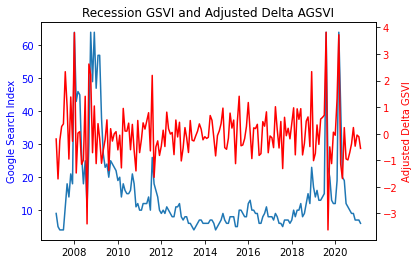

Mean: 0.000000, StandardDeviation: 0.362335


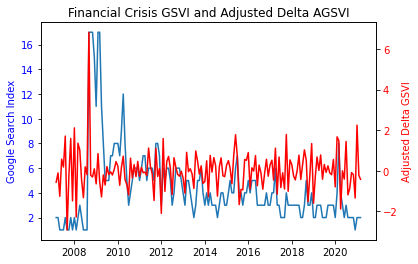

Mean: -0.000000, StandardDeviation: 0.442276


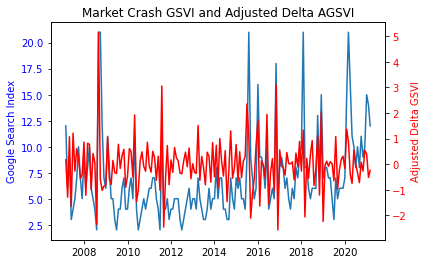

Mean: 0.000000, StandardDeviation: 0.158684


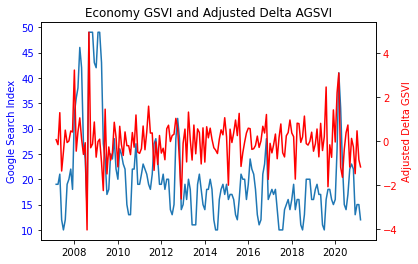

In [16]:
# Apply fearsindex() function to compute all values required to calculate the fears index
data1 = fearsindex_df(dt)

In [17]:
# Check if the table has the correct format (Beware It gonna be a Large Table!)
pd.set_option('display.max_columns', None)
data1

,Recession,Financial Crisis,Market Crash,Economy,isPartial,t,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,Recession_deltaGSVI,Recession_deltaGSVI_residual,Recession_Adjusted_deltaGSVI,Financial Crisis_deltaGSVI,Financial Crisis_deltaGSVI_residual,Financial Crisis_Adjusted_deltaGSVI,Market Crash_deltaGSVI,Market Crash_deltaGSVI_residual,Market Crash_Adjusted_deltaGSVI,Economy_deltaGSVI,Economy_deltaGSVI_residual,Economy_Adjusted_deltaGSVI
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2007-03-01,9,2,12,19,False,1,0,1,0,0,0,0,0,0,0,0,0,0.000000,-0.063848,-0.200063,0.000000,-0.205410,-0.566908,0.000000,0.077063,0.174241,0.000000,0.008024,0.050566
2007-04-01,5,2,6,19,False,2,0,0,1,0,0,0,0,0,0,0,0,-0.587787,-0.544305,-1.705539,0.000000,-0.040066,-0.110576,-0.693147,-0.570581,-1.290101,0.000000,-0.027683,-0.174456
2007-05-01,4,1,9,21,False,3,0,0,0,1,0,0,0,0,0,0,0,-0.223144,-0.082910,-0.259792,-0.693147,-0.456951,-1.261130,0.405465,0.475028,1.074054,0.100083,0.202907,1.278684
2007-06-01,4,1,3,12,False,4,0,0,0,0,1,0,0,0,0,0,0,0.000000,0.086004,0.269487,0.000000,0.207049,0.571429,-1.098612,-0.729247,-1.648850,-0.559616,-0.217577,-1.371131
2007-07-01,4,1,4,10,False,5,0,0,0,0,0,1,0,0,0,0,0,0.000000,0.117625,0.368569,0.000000,0.066361,0.183149,0.287682,0.536871,1.213883,-0.182322,-0.080187,-0.505324
2007-08-01,11,2,5,12,False,6,0,0,0,0,0,0,1,0,0,0,0,1.011601,0.744916,2.334140,0.693147,0.617947,1.705459,0.223144,-0.120382,-0.272187,0.182322,0.077013,0.485321
2007-09-01,18,1,7,19,False,7,0,0,0,0,0,0,0,1,0,0,0,0.492476,0.323485,1.013615,-0.693147,-1.057384,-2.918253,0.336472,0.269026,0.608276,0.459532,-0.012517,-0.078882
2007-10-01,14,1,10,20,False,8,0,0,0,0,0,0,0,0,1,0,0,-0.251314,-0.305520,-0.957326,0.000000,-0.084183,-0.232334,0.356675,0.100718,0.227728,0.051293,-0.000795,-0.005008
2007-11-01,21,2,7,22,False,9,0,0,0,0,0,0,0,0,0,1,0,0.405465,0.440919,1.381588,0.693147,0.575962,1.589586,-0.356675,-0.248199,-0.561185,0.095310,0.070962,0.447191


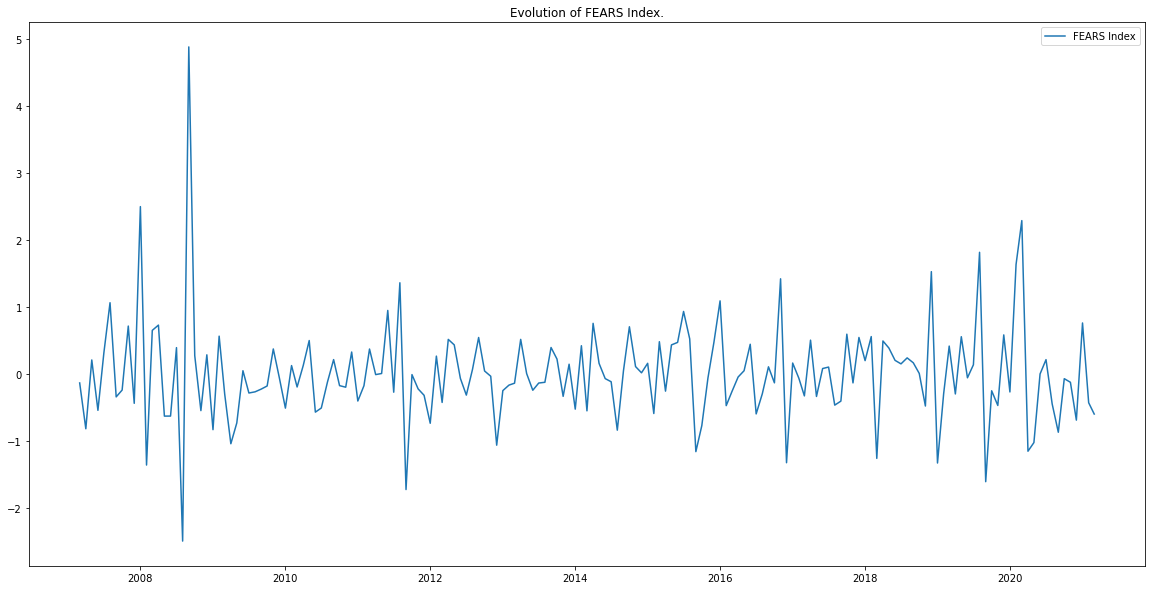

In [18]:
data1 = fears(data1)

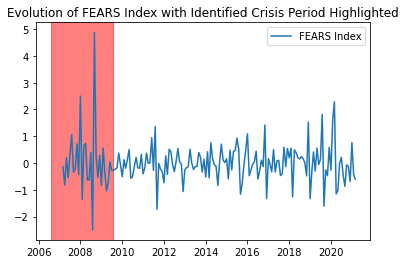

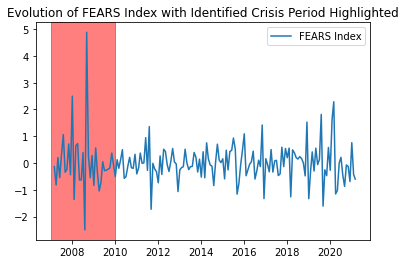

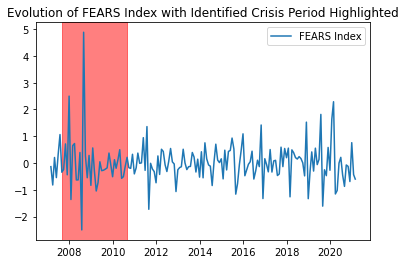

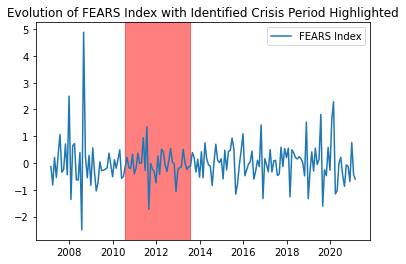

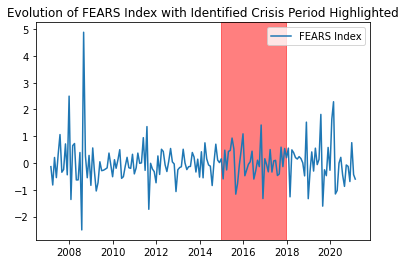

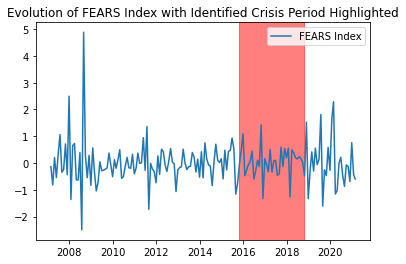

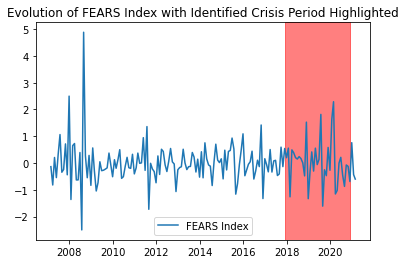

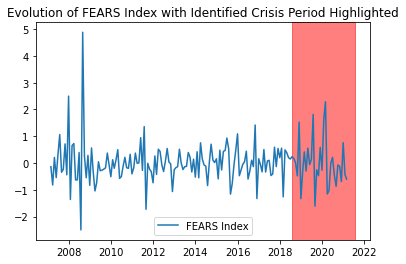

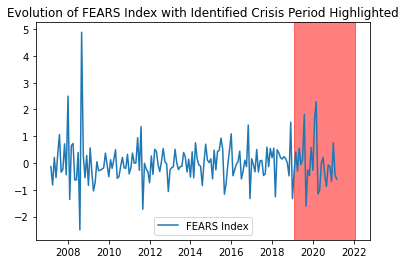

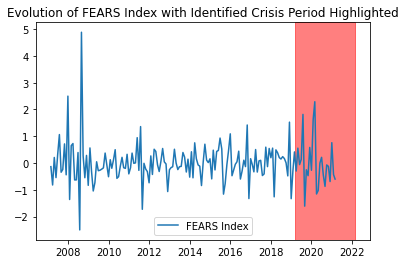

In [19]:
crisis_period = crisis(data1)

In [20]:
# Check if the table has the correct format 
crisis_period

,Crisis Date,Start,End
0,2007-08-01,2006-08-02,2009-07-29
1,2008-01-01,2007-01-02,2009-12-29
2,2008-09-01,2007-09-03,2010-08-30
3,2011-08-01,2010-08-02,2013-07-29
4,2016-01-01,2015-01-02,2017-12-29
5,2016-11-01,2015-11-03,2018-10-30
6,2018-12-01,2017-12-02,2020-11-28
7,2019-08-01,2018-08-02,2021-07-29
8,2020-02-01,2019-02-02,2022-01-29
9,2020-03-01,2019-03-03,2022-02-27


# Sentiment Analysis - Reddit

## Detection Formula

In [21]:
# Define the Hypothesis Function
def HTS(array1, array2): ### ref: reference window, det: detection window
    ref = array1
    det = array2 ### These two lines are reserved for easy change to a different HT function.
    tset, pval = stats.ttest_ind(det, ref)
    return pval

In [22]:
# Define the Anomaly Detection Function.
def FindAnomaly_S(GME_count_Reddit, size = 5): ### size: window size (default = 5)
    if len(GME_count_Reddit) < size:
        print("Not enough data.")
    else:
        for i in range(len(GME_count_Reddit)-(2*size-1)):
            ref_W = GME_count_Reddit['Count'][i:i+size]
            det_W = GME_count_Reddit['Count'][i+size:i+2*size]
            print("Date:", GME_count_Reddit['Date'][i+size]) ###
            pval = HTS(ref_W, det_W)
            print("The p-value is:", pval)
            if pval < 0.05:
                print("Anomaly Pattern Detected!!!!!")
            else:
                print("No Anomlay Detected.")

In [23]:
# Define the Record Anomaly Function. (This function will store all the anomalies into a dataframe)
def RecordAnomaly_S(GME_count_Reddit, vr, size):
    anomaly = {'Date':[], 
               vr:[]}
    if len(GME_count_Reddit) < size+5:
        print("Not enough data.")
    else:
        for i in range(len(GME_count_Reddit)-(2*size-1)):
            ref_W = GME_count_Reddit['Count'][i:i+size]
            det_W = GME_count_Reddit['Count'][i+size:i+2*size]
            pval = HTS(ref_W, det_W)
            if pval < 0.05:
                anomaly['Date'].append(GME_count_Reddit['Date'][i+size]) ###
                anomaly[vr].append(GME_count_Reddit['Count'][i+size]) ###
    return anomaly

## Compute Volume of Sentiments

In [24]:
# Dataframe Display Configuration
pd.set_option('display.max_rows', 500)

# IMPORTANT: Change REDDIT Sentiment INPUT Here

In [422]:
# Read the Combined Data
R_sen = pd.read_excel(r'Data\Reddit_NOKIA_sentiments.xlsx')
# R_sen = pd.read_csv(r'Data\Reddit_GME_Sentiments.csv') ### Use this one for CSV files (GME, SP, DJ)

# #################################

In [423]:
# Convert Date to datetime Format
R_sen['Date'] = pd.to_datetime(R_sen['Date'])

In [424]:
R_sen

,created_utc,title,url,Date
0,1614474077,$VISL $TRCH $NOK $ITRM,https://www.reddit.com/r/wallstreetbets/commen...,2021-02-28 01:01:17
1,1614458109,https://www.nokia.com/about-us/news/releases/2...,https://www.reddit.com/r/wallstreetbets/commen...,2021-02-27 20:35:09
2,1614458025,Nokia is literally GOING TO THE MOON!! Let’s s...,https://www.reddit.com/r/wallstreetbets/commen...,2021-02-27 20:33:45
3,1614452740,Nok 🚀🚀🚀,https://www.reddit.com/r/wallstreetbets/commen...,2021-02-27 19:05:40
4,1614448885,What's up with Nokia there 3.92 a share could ...,https://www.reddit.com/r/wallstreetbets/commen...,2021-02-27 18:01:25
...,...,...,...,...
27968,1569418657,Morning Briefing (9/25/2019),https://www.reddit.com/r/wallstreetbets/commen...,2019-09-25 13:37:37
27969,1569250041,$NOK calls will do well,https://www.reddit.com/r/wallstreetbets/commen...,2019-09-23 14:47:21
27970,1569244344,Morning Briefing (9/23/2019),https://www.reddit.com/r/wallstreetbets/commen...,2019-09-23 13:12:24
27971,1568643027,Morning Briefing (9/16/2019),https://www.reddit.com/r/wallstreetbets/commen...,2019-09-16 14:10:27


In [425]:
# Delete Duplicate
R_sen.drop_duplicates(subset = ["title", "url"], keep = False, inplace = True)

In [426]:
# Check Data
R_sen

,created_utc,title,url,Date
0,1614474077,$VISL $TRCH $NOK $ITRM,https://www.reddit.com/r/wallstreetbets/commen...,2021-02-28 01:01:17
1,1614458109,https://www.nokia.com/about-us/news/releases/2...,https://www.reddit.com/r/wallstreetbets/commen...,2021-02-27 20:35:09
2,1614458025,Nokia is literally GOING TO THE MOON!! Let’s s...,https://www.reddit.com/r/wallstreetbets/commen...,2021-02-27 20:33:45
3,1614452740,Nok 🚀🚀🚀,https://www.reddit.com/r/wallstreetbets/commen...,2021-02-27 19:05:40
4,1614448885,What's up with Nokia there 3.92 a share could ...,https://www.reddit.com/r/wallstreetbets/commen...,2021-02-27 18:01:25
...,...,...,...,...
27968,1569418657,Morning Briefing (9/25/2019),https://www.reddit.com/r/wallstreetbets/commen...,2019-09-25 13:37:37
27969,1569250041,$NOK calls will do well,https://www.reddit.com/r/wallstreetbets/commen...,2019-09-23 14:47:21
27970,1569244344,Morning Briefing (9/23/2019),https://www.reddit.com/r/wallstreetbets/commen...,2019-09-23 13:12:24
27971,1568643027,Morning Briefing (9/16/2019),https://www.reddit.com/r/wallstreetbets/commen...,2019-09-16 14:10:27


In [427]:
# Sort by Date
R_sen = R_sen.sort_values('Date')

In [428]:
# Keep the Columns needed and Reset Index
R_sen_sort = R_sen[['Date', 'title', 'url']].reset_index()
del R_sen_sort['index']

In [429]:
# Rename the column names to 
R_sen_sort.rename(columns={"title": "Title"})

,Date,Title,url
0,2019-09-03 13:13:41,Morning Briefing (9/3/2019),https://www.reddit.com/r/wallstreetbets/commen...
1,2019-09-16 14:10:27,Morning Briefing (9/16/2019),https://www.reddit.com/r/wallstreetbets/commen...
2,2019-09-23 13:12:24,Morning Briefing (9/23/2019),https://www.reddit.com/r/wallstreetbets/commen...
3,2019-09-23 14:47:21,$NOK calls will do well,https://www.reddit.com/r/wallstreetbets/commen...
4,2019-09-25 13:37:37,Morning Briefing (9/25/2019),https://www.reddit.com/r/wallstreetbets/commen...
...,...,...,...
27954,2021-02-27 18:01:25,What's up with Nokia there 3.92 a share could ...,https://www.reddit.com/r/wallstreetbets/commen...
27955,2021-02-27 19:05:40,Nok 🚀🚀🚀,https://www.reddit.com/r/wallstreetbets/commen...
27956,2021-02-27 20:33:45,Nokia is literally GOING TO THE MOON!! Let’s s...,https://www.reddit.com/r/wallstreetbets/commen...
27957,2021-02-27 20:35:09,https://www.nokia.com/about-us/news/releases/2...,https://www.reddit.com/r/wallstreetbets/commen...


In [430]:
# Count Posts Group By Dates
# Attribute: https://stackoverflow.com/questions/52182967/python-pandas-group-by-date-and-count
# Author: jezrael

R_count_Reddit = R_sen_sort['Date'].dt.date.value_counts().sort_index().reset_index()

In [431]:
# Rename Dataframe
R_count_Reddit = R_count_Reddit.rename(columns={"index": "Date", "Date": "Count"})

In [432]:
# Remove Extra Data Points
R_count_Reddit['Date'] = pd.to_datetime(R_count_Reddit['Date'])
R_count_Reddit = R_count_Reddit[~(R_count_Reddit['Date'] > '2021-02-11')]

Text(0.5, 1.0, 'Daily Count of Related Posts in r/WallStreetBets')

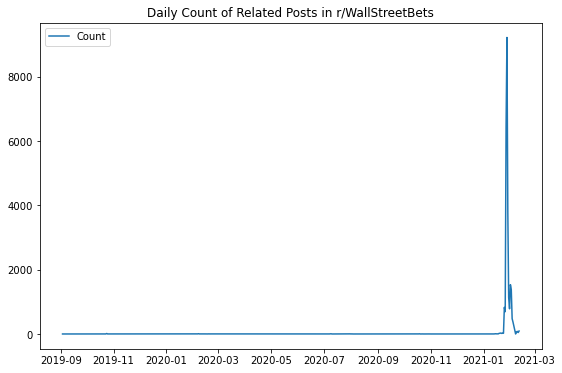

In [433]:
# Visulisation
pp.figure(figsize=(9,6))
pp.plot(R_count_Reddit.Date, R_count_Reddit.Count, label = 'Count')
pp.legend(loc = 'best')
pp.title('Daily Count of Related Posts in r/WallStreetBets')

In [434]:
# Run the Detection Method
FindAnomaly_S(R_count_Reddit)

Date: 2019-10-08 00:00:00
The p-value is: 0.6665811073830707
No Anomlay Detected.
Date: 2019-10-15 00:00:00
The p-value is: 0.3972038407802937
No Anomlay Detected.
Date: 2019-10-19 00:00:00
The p-value is: 0.27183691332185733
No Anomlay Detected.
Date: 2019-10-21 00:00:00
The p-value is: 0.21440640986369505
No Anomlay Detected.
Date: 2019-10-22 00:00:00
The p-value is: 0.29948989697842365
No Anomlay Detected.
Date: 2019-10-23 00:00:00
The p-value is: 0.26370362272317677
No Anomlay Detected.
Date: 2019-10-24 00:00:00
The p-value is: 0.32872042455250955
No Anomlay Detected.
Date: 2019-10-25 00:00:00
The p-value is: 0.32872042455250955
No Anomlay Detected.
Date: 2019-10-26 00:00:00
The p-value is: 0.26370362272317677
No Anomlay Detected.
Date: 2019-10-28 00:00:00
The p-value is: 0.26915310688181554
No Anomlay Detected.
Date: 2019-10-29 00:00:00
The p-value is: 0.21178265210422756
No Anomlay Detected.
Date: 2019-10-30 00:00:00
The p-value is: 0.24309463562888134
No Anomlay Detected.
Date: 

In [435]:
# Record Unusual Investor Attention
R_Anomaly = RecordAnomaly_S(R_count_Reddit, "Unusual Investor Attention", 5)
Reddit_Anomaly = pd.DataFrame(R_Anomaly)
display(Reddit_Anomaly)

,Date,Unusual Investor Attention
0,2019-11-03,1
1,2020-03-07,1
2,2020-05-30,1
3,2020-06-01,2
4,2020-07-22,2
5,2020-07-28,2
6,2020-08-03,1
7,2020-10-17,3
8,2020-12-13,1
9,2021-01-13,2


# Sentiment Analysis - Twitter

# IMPORTANT: Change TWITTER Sentiment INPUT Here

In [436]:
# Read the Combined Data (AMC & GME has Part 1 & 2)
# sen_T1 = pd.read_csv(r'Data\GME_Twitter_Part1.csv')
# sen_T2 = pd.read_csv(r'Data\GME_Twitter_Part2.csv')
# sen_T = sen_T1.append(sen_T2, ignore_index=True)

sen_T = pd.read_csv(r'Data\NOK_Twitter.csv') ###

# #################################

In [437]:
# Convert Date to datetime Format
sen_T['Date'] = pd.to_datetime(sen_T['Date'])

In [438]:
# Remove Extra Data Points
sen_T['Date'] = pd.to_datetime(sen_T['Date'])
sen_T = sen_T[~(sen_T['Date'] > '2021-02-11')]

In [439]:
# Rename Dataframe
sen_T = sen_T.rename(columns={"Frequency": "Count"})

In [440]:
sen_T

,Date,Count
0,2019-08-02,2
1,2019-08-03,1
2,2019-08-04,0
3,2019-08-05,1
4,2019-08-06,7
...,...,...
555,2021-02-07,113
556,2021-02-08,266
557,2021-02-09,223
558,2021-02-10,229


Text(0.5, 1.0, 'Daily Count of Related Tweets on Twitter')

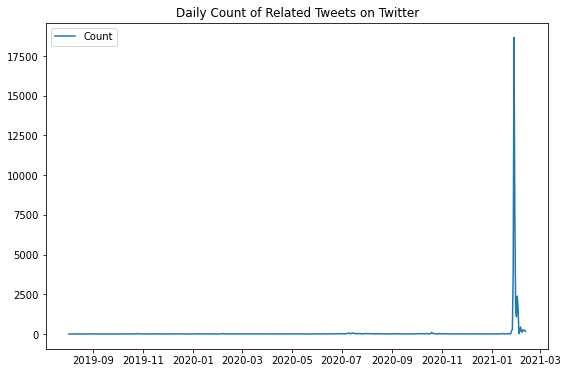

In [441]:
# Visulisation
pp.figure(figsize=(9,6))
pp.plot(sen_T.Date, sen_T.Count, label = 'Count')
pp.legend(loc = 'best')
pp.title('Daily Count of Related Tweets on Twitter')

In [442]:
# Run the Detection Method
FindAnomaly_S(sen_T)

Date: 2019-08-07 00:00:00
The p-value is: 0.5959933066795502
No Anomlay Detected.
Date: 2019-08-08 00:00:00
The p-value is: 0.6937998380169583
No Anomlay Detected.
Date: 2019-08-09 00:00:00
The p-value is: 1.0
No Anomlay Detected.
Date: 2019-08-10 00:00:00
The p-value is: 0.78342440625
No Anomlay Detected.
Date: 2019-08-11 00:00:00
The p-value is: 0.8893740251728112
No Anomlay Detected.
Date: 2019-08-12 00:00:00
The p-value is: 0.6195437484575322
No Anomlay Detected.
Date: 2019-08-13 00:00:00
The p-value is: 0.8195856784525776
No Anomlay Detected.
Date: 2019-08-14 00:00:00
The p-value is: 0.4875996168424147
No Anomlay Detected.
Date: 2019-08-15 00:00:00
The p-value is: 0.6665811073830705
No Anomlay Detected.
Date: 2019-08-16 00:00:00
The p-value is: 0.225571973816597
No Anomlay Detected.
Date: 2019-08-17 00:00:00
The p-value is: 0.20730483995919904
No Anomlay Detected.
Date: 2019-08-18 00:00:00
The p-value is: 0.5447373008044909
No Anomlay Detected.
Date: 2019-08-19 00:00:00
The p-valu

The p-value is: 0.5403104285819047
No Anomlay Detected.
Date: 2020-04-17 00:00:00
The p-value is: 0.3972038407802939
No Anomlay Detected.
Date: 2020-04-18 00:00:00
The p-value is: 0.03260517203081879
Anomaly Pattern Detected!!!!!
Date: 2020-04-19 00:00:00
The p-value is: 0.12204619703254396
No Anomlay Detected.
Date: 2020-04-20 00:00:00
The p-value is: 0.26225475040217827
No Anomlay Detected.
Date: 2020-04-21 00:00:00
The p-value is: 0.17501975194494848
No Anomlay Detected.
Date: 2020-04-22 00:00:00
The p-value is: 0.44055142736612396
No Anomlay Detected.
Date: 2020-04-23 00:00:00
The p-value is: 0.4348922976747406
No Anomlay Detected.
Date: 2020-04-24 00:00:00
The p-value is: 0.896069217732034
No Anomlay Detected.
Date: 2020-04-25 00:00:00
The p-value is: 0.886431406090333
No Anomlay Detected.
Date: 2020-04-26 00:00:00
The p-value is: 0.4167162416790581
No Anomlay Detected.
Date: 2020-04-27 00:00:00
The p-value is: 0.23469509887040013
No Anomlay Detected.
Date: 2020-04-28 00:00:00
The

Date: 2020-12-14 00:00:00
The p-value is: 0.6177362329680876
No Anomlay Detected.
Date: 2020-12-15 00:00:00
The p-value is: 0.24892254540739295
No Anomlay Detected.
Date: 2020-12-16 00:00:00
The p-value is: 0.48662293186488137
No Anomlay Detected.
Date: 2020-12-17 00:00:00
The p-value is: 0.5277345432847929
No Anomlay Detected.
Date: 2020-12-18 00:00:00
The p-value is: 0.6191842908601367
No Anomlay Detected.
Date: 2020-12-19 00:00:00
The p-value is: 0.1888546061333978
No Anomlay Detected.
Date: 2020-12-20 00:00:00
The p-value is: 0.8619282156106918
No Anomlay Detected.
Date: 2020-12-21 00:00:00
The p-value is: 0.598827136697289
No Anomlay Detected.
Date: 2020-12-22 00:00:00
The p-value is: 0.22772401289749156
No Anomlay Detected.
Date: 2020-12-23 00:00:00
The p-value is: 0.179841999276821
No Anomlay Detected.
Date: 2020-12-24 00:00:00
The p-value is: 0.9081338932931234
No Anomlay Detected.
Date: 2020-12-25 00:00:00
The p-value is: 0.7282695142403168
No Anomlay Detected.
Date: 2020-12-2

In [443]:
# Record Unusual Investor Attention
T_Anomaly = RecordAnomaly_S(sen_T, "Unusual Investor Attention", 5)
Twitter_Anomaly = pd.DataFrame(T_Anomaly)
display(Twitter_Anomaly)

,Date,Unusual Investor Attention
0,2019-10-08,4
1,2019-10-31,3
2,2019-11-02,2
3,2019-11-03,1
4,2019-12-21,0
5,2020-01-10,4
6,2020-01-11,1
7,2020-02-05,3
8,2020-02-06,22
9,2020-02-12,4


# Format Data

### Read from CSV

In [444]:
# define formating function
def format_csv(csv_title):
    df = pd.read_csv(csv_title, index_col = 'Date') ### data as index 
    df = df[['Adj Close']] ### drop all other columns
    df['Return'] = (df['Adj Close'] / df['Adj Close'].shift(1)) - 1 ### compute return
    df['Return'] = df['Return'].fillna(0) ### replace NaN with 0
    df.index = pd.to_datetime(df.index) ### datatype conversion
    return df

In [445]:
def format_csv2(csv_title):
    df = pd.read_csv(csv_title, index_col = 'Date') ### data as index 
    df = df[[' Close']] ### drop all other columns
    df['Return'] = (df[' Close'] / df[' Close'].shift(1)) - 1 ### compute return
    df['Return'] = df['Return'].fillna(0) ### replace NaN with 0
    df.index = pd.to_datetime(df.index) ### datatype conversion
    return df

## Detrend & Smoothing

### Log Transformation & Detrend

In [446]:
# Attribute: https://github.com/srafay/Time-Series-Analysis-JetRail/blob/f5c25f4d481ddb8deaea09f2cff2d8585dcf6bb4/Jet_Rail.py#L197
# Author: Syed Rafay
# 2nd Attribute: Recommended & Reviewed by
# Author: Zhaolin

def test_stationarity(timeseries, w, title='Rolling Mean & Standard Deviation'): ### w: window size
    #Determing rolling statistics
    rolmean = timeseries.rolling(center=False,window=w).mean()
    rolstd = timeseries.rolling(center=False,window=w).std()
    #Plot rolling statistics:
    pp.figure(figsize=(20,10))
    orig = pp.plot(timeseries, color='blue',label='Original')
    mean = pp.plot(rolmean, color='red', label='Rolling Mean')
    std = pp.plot(rolstd, color='green', label = 'Rolling Std')
    pp.legend(loc='best')
    pp.title(title)
    pp.show(block=False)
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

def detrend_takelog(df, w): ### df: dt['']; w: window size 
    # plot raw data 
    pp.figure(figsize=(20,10))
    pp.plot(df.index.values, df.values)
    pp.title('Original Time Series Data')
    pp.show()
    # log transormation
    Train_log = np.log(df['Adj Close'])
    moving_avg = Train_log.rolling(w).mean()
    # plot logged trainning data
    pp.figure(figsize=(20,10))
    pp.plot(df.index.values, Train_log.values, label='log(train)')
    pp.plot(df.index.values, moving_avg.values, color = 'red', label='Rolling_Mean(log(train))')
    pp.legend(loc='best')
    pp.title('Transforming series by taking the log')
    pp.show()
    # Remove the trend
    train_log_moving_avg_diff = Train_log - moving_avg
    ### option 1: NaN replaced by 0
    ### train_log_moving_avg_diff = train_log_moving_avg_diff.fillna(0) 
    ### option 2: drop NaN
    train_log_moving_avg_diff.dropna(inplace = True)
    test_stationarity(train_log_moving_avg_diff, w) # And from plot we can see that std is stable
    return train_log_moving_avg_diff.to_frame()

### Log Transformation

In [447]:
def takelog(df, w = 5): ### df: dt['']; w: window size 
    # plot raw data 
    pp.figure(figsize=(20,10))
    pp.plot(df.index.values, df.values)
    pp.title('Original Time Series Data')
    pp.show()
    # log transormation
    Train_log = np.log(df['Adj Close'])
    # plot logged trainning data
    pp.figure(figsize=(20,10))
    pp.plot(df.index.values, Train_log.values, label='log(train)')
    pp.legend(loc='best')
    pp.title('Transforming series by taking the log')
    pp.show()
    test_stationarity(Train_log, w) # And from plot we can see that std is stable
    return Train_log.to_frame()

In [448]:
# Random-Walk Model Synthetic Data
### Check cosine similarity measure - Euclidean Distance b/w two points/vector.

# Machine Learning


## Define Functions

In [449]:
# Define Transformation Function that converts data into t chunks of equal length - for Adjusted Close Price
def transform(df_t, va, t): ### df_t: time-series data, va: variable, t: length of chunks
    X_array = np.array(df_t[[va]].dropna(inplace = False)) ### Convert X into Array
    residue = len(X_array) % t
    if residue:
        print("The array is not divisible into a", t, "dimensional array.")
        print("We omit the first", residue, "entry/entries in the dataset.")
    X_array = X_array[residue:] ### Crop the data into length divisible by t
    X_t = np.reshape(X_array, (-1, t)) ### Reshape for fitting
    return X_t

In [450]:
# Define Model Fit Function - Training
def DTWfit(X_t):
    model_X_temp = TimeSeriesKMeans(n_clusters = number_of_clusters, metric = algorithm, max_iter = 25)
    model_X_temp.fit(X_t) ### Fit the Model
    Xc = model_X_temp.cluster_centers_
    XL = model_X_temp.labels_
    s = min_size ### smallest cluster size
    idx = []
    for i in range(number_of_clusters): ### define functions to find clusters smaller than s
        if np.count_nonzero(XL == i) <= s:
            idx.append(i)
            print(len(idx), "cluster has a size smaller than", s, "and is removed.")
    Xc = np.delete(Xc, idx, axis = 0) ### remove clusters smaller than s
    if len(idx) == 0:
        model_X = model_X_temp
    else:
        model_X = TimeSeriesKMeans(n_clusters = len(Xc), metric = algorithm, max_iter = 25)
        model_X.fit(X_t) ### Fit the model again using updated cluster-size.
    return model_X

In [451]:
# Define Distance Function
def dtw_dist(x, y):
    distance, path = fastdtw(x, y, dist = euclidean)
    return distance

In [452]:
# Define Threshold Function - Training
def find_threshold(X_t, m = 3): ### X_t is training dataset; m: multiplier (default is 3)
    XDM = []
    d_X = model_X.cluster_centers_
    XL = model_X.labels_
    for i in range (len(X_t)): # Compute Union of Distance Matrix
        j = XL[i]
        dist = dtw_dist(X_t[i], d_X[j]) 
        XDM.append(dist)
    q75, q25 = np.percentile(XDM, [75 ,25])
    iqr = q75 - q25 ### Compute inter-quartile range
    X_threshold = m * max(XDM) ### Define threshold using max-distance in traning data-set (three-scaled reference Diab et al.)
    print("The max distance found is", max(XDM), ".")
    print("The inter-quartile range is", iqr, ".")
    print("The max-distance threshold for a new data point to be not classifed as an outlier is", X_threshold, ".")
    print("The full distance matrixs are with a size of", len(XDM), ":")
    print(np.reshape(XDM, (-1)))
    return X_threshold

In [453]:
# Rolling window for data streaming mode (note: this step only models the streaming process using method of iteration, 
# it should not to be applied directly to an actual data stream)
def window(seq, n = 5): ### n: size of the window
    it = iter(seq)
    win = tuple(islice(it, n))
    if len(win) == n:
        yield np.array(win)
    for e in it:
        win = win[1:] + (e,)
        yield np.array(win)

In [454]:
# Define Labelling Function Component
def Label(X_in, Threshold): ### X_in: Streaming Input
    X_int = [X_in]
    d_X = model_X.cluster_centers_
    j = model_X.predict(X_int)[0]
    d = dtw_dist(np.reshape(X_in, (5,1)), d_X[j]) ###
    print("The distance is:", d)
    if d > Threshold:
        return 1
    else:
        return 0

In [455]:
# Define Labelling Function
def labeling_X(inputs, threshold, X_lb): ### inputs: Data to be detected, X_lb: array to store the label
    nt = next(inputs, "Err")
    if isinstance(nt, str) == True:
        print ("no more value")
    else:
        nt = nt.reshape(5, 1)
        tl = Label(nt, threshold)
        X_lb.append(tl)
        print("Time series:")
        print(nt)
        print("is labeled as", tl, ".")
        print("Current labels are:")
        print(X_lb)

In [456]:
# Define the Hypothesis Function
def HT(array1, array2): ### ref: reference window, det: detection window
    ref = array1
    det = array2 ### These two lines are reserved for easy change to a different HT function.
    tset, pval = stats.ttest_ind(det, ref)
    return pval

In [457]:
# Define the Anomaly Detection Function.
def FindAnomaly(X_lb, size): ### size: window size (default = 5)
    if len(X_lb) < size:
        print("Not enough data.")
    else:
        ref_W = X_lb[0:size]
        for i in range(len(X_lb)-(size-1)):
            det_W = X_lb[i:i+size]
            print("Date:", X.index[i+size]) ###
            pval = HT(ref_W, det_W)
            print("The p-value is:", pval)
            if pval < 0.05:
                print("Anomaly Pattern Detected!!!!!")
            else:
                print("No Anomlay Detected.")

In [458]:
# Define the Record Anomaly Function. (This function will store all the anomalies into a dataframe)
def RecordAnomaly(X_lb, vr, size):
    Anomaly = {'Date':[], 
               vr:[]}
    if len(X_lb) < size:
        print("Not enough data.")
    else:
        ref_W = X_lb[0:size]
        for i in range(len(X_lb)-(size-1)):
            det_W = X_lb[i:i+size]
            pval = HT(ref_W, det_W)
            if pval < 0.05:
                Anomaly['Date'].append(X.index[i+size]) ###
                Anomaly[vr].append(X[i+size]) ###
    return Anomaly

In [459]:
# Define Function that signals the first Anomaly Pattern Instance
def SignalAnomaly(X_lb, size):
        if len(X_lb) < size:
            print("Not enough data.")
        else:
            ref_W = X_lb[0:size]
        for i in range(len(X_lb)-(size-1)):
            det_W = X_lb[i:i+size]
            pval = HT(ref_W, det_W)
            if pval < 0.05:
                return X.index[i+size] ###

In [460]:
# Visualisation for DTW

### Attribute: https://tslearn.readthedocs.io/en/stable/auto_examples/clustering/plot_kmeans.html#sphx-glr-auto-examples-clustering-plot-kmeans-py
### Arthor: M. Cuturi, M. Blondel “Soft-DTW: a Differentiable Loss Function for Time-Series,” ICML 2017.
# 2nd Attribute: Recommended & Reviewed by
# Author: Zhaolin

def visualise_clustering(X_train, ts):
    lens = len(model_X.cluster_centers_)
    sz = X_train.shape[1]-1
    print("DTW k-means")
    y_pred = model_X.predict(X_train)
    print("Labels:")
    print(model_X.labels_)
    pp.figure(figsize = (10, 10))
    for yi in range(lens):
        pp.subplot(3, lens, 1 + yi)
        for xx in X_train[y_pred == yi]:
            pp.plot(xx.ravel(), "k-", alpha = .2)
        pp.plot(model_X.cluster_centers_[yi].ravel(), "r-")
        pp.xlim(0, sz)
        pp.ylim(ts.min(), ts.max()) ### range needs to be customizable
        pp.text(0.55, 0.85,'Cluster %d' % (yi + 1), transform = pp.gca().transAxes)
        if yi == 1:
            pp.title("DTW $k$-means")
    pp.tight_layout()
    pp.show()
    return

In [461]:
# Visualisation for Anomaly Pattern Signal
def plotAnomaly(df, vr): ### df: dataframe, vr: variable "Adj Close", "Return"..., lb: Label ""
    pp.figure(figsize = (20, 10))
    pp.plot(df[vr], label = vr)
    if len(Anomaly_Table) > 0:
        pp.axvline(x = Anomaly_Table['Date'][0], color = 'red', label = Anomaly_Table['Date'][0])
        pp.axhline(y = Anomaly_Table[vr][0], color = 'red', label = Anomaly_Table[vr][0])
    pp.legend(loc='best')
    pp.title('Anomaly Pattern Signal')
    pp.show
    print("1st Anomaly Instance Detected at:", Anomaly_Table.head(1))

# Normalised Return; Daily

This part of the modelling is completed with the following data structure:

**Training Data**
- Period: 01/08/2019 - 31/08/2020
- Length: 273
- Interval: daily
- Attribute: Adj Close
- Log: Yes
- Detrend: Yes

**Testing Data**
- Period: 01/09/2020 - 11/02/2021
- Length: 106
- Interval: daily
- Attribute: Adj Close
- Log: Yes
- Detrend: Yes


## DTW K-mean Clustering - Training

# IMPORTANT: Change TRAINING data INPUT Here

In [462]:
# Read GME Training Data
df_train = format_csv(r'Data\NOK_train.csv')

# df_train = format_csv2(r'Data\DJ_train.csv')

# #################################

In [463]:
# Check data has loaded correctly
df_train

,Adj Close,Return
Date,,
2019-08-01,5.37,0.000000
2019-08-02,5.40,0.005587
2019-08-05,5.29,-0.020370
2019-08-06,5.35,0.011342
2019-08-07,5.32,-0.005607
2019-08-08,5.40,0.015038
2019-08-09,5.41,0.001852
2019-08-12,5.31,-0.018484
2019-08-13,5.33,0.003766


In [464]:
# Transform the data.
X_t = transform(df_train, 'Return', 5)

The array is not divisible into a 5 dimensional array.
We omit the first 3 entry/entries in the dataset.


In [465]:
# Check the data has transformed correctly
X_t

array([[ 0.01134216, -0.00560748,  0.01503759,  0.00185185, -0.01848429],
       [ 0.00376648, -0.03939962, -0.01171875,  0.02173913,  0.01160542],
       [-0.01529637,  0.0038835 , -0.01934236, -0.01183432, -0.00199601],
       [-0.012     , -0.01012146,  0.00613497,  0.00813008, -0.01814516],
       [ 0.00821355,  0.01221996,  0.00804829,  0.00199601,  0.01593625],
       [ 0.        ,  0.02745098, -0.01145038, -0.01158301,  0.00585938],
       [-0.00194175,  0.00194553,  0.02718447, -0.02079395, -0.01544402],
       [-0.00588235, -0.01577909,  0.01002004,  0.00396825, -0.02964427],
       [-0.01832994,  0.00414938,  0.01033058,  0.00408998, -0.00203666],
       [ 0.00204082,  0.00610998,  0.01619433, -0.01394422,  0.01212121],
       [ 0.01596806,  0.02750491, -0.00573614,  0.        , -0.00384615],
       [-0.01351351, -0.23679061, -0.03076923, -0.05026455, -0.01114206],
       [ 0.02816901,  0.        ,  0.00273973, -0.0136612 , -0.01939058],
       [ 0.01412429, -0.00557103,  0. 

## DTW Varient Here

In [466]:
# assign DTWfit(X_t) parameters
number_of_clusters = 3
algorithm = "dtw" ### "dtw" or "euclidean" (distance computation method)
min_size = int(X_t.shape[0] * 0.05) ### cluster with less than 5% of total sample

In [467]:
# Fit the traning data.
model_X = DTWfit(X_t)
model_X.cluster_centers_ ### Check the cluster centroids

1 cluster has a size smaller than 2 and is removed.


array([[[ 0.00879547],
        [ 0.01773674],
        [-0.01610478],
        [ 0.00522714],
        [-0.00398253]],

       [[-0.03537121],
        [-0.2014624 ],
        [ 0.0095196 ],
        [-0.08352644],
        [ 0.01715624]]])

DTW k-means
Labels:
[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


C:\Users\senyu\anaconda3\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 54 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


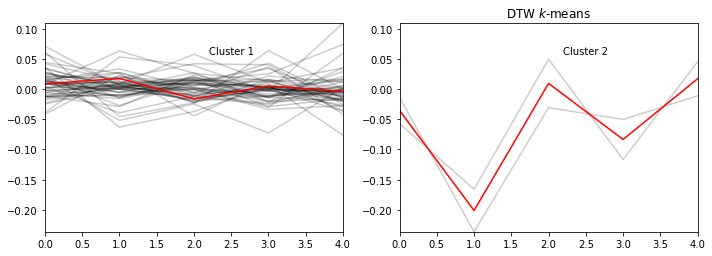

In [468]:
# DTW Visualisation
visualise_clustering(X_t, df_train['Return'])

### note: because the detrended data using log and moving average will result in extremely small values, which will lead
###       to similar cluster centroids more often than original data.

# IMPORTANT: Change THRESHOLD MULTIPLIER Here

In [469]:
# Find Threshold and save the value
Threshold = find_threshold(X_t, 1)

The max distance found is 0.24015654608684162 .
The inter-quartile range is 0.05196402308603701 .
The max-distance threshold for a new data point to be not classifed as an outlier is 0.24015654608684162 .
The full distance matrixs are with a size of 54 :
[0.04712607 0.07878006 0.05466279 0.0726104  0.05340168 0.03816002
 0.06385671 0.07033613 0.06245545 0.03614092 0.03267292 0.15903493
 0.07348475 0.03360731 0.08634673 0.07017438 0.0150195  0.0428027
 0.05428723 0.04678381 0.07538513 0.05442477 0.05953127 0.07504222
 0.05309793 0.1197241  0.06640881 0.11268082 0.16464558 0.12053519
 0.15903493 0.24015655 0.10052164 0.12621323 0.10424347 0.09679005
 0.07218456 0.04397058 0.07747278 0.12687558 0.05837003 0.10589091
 0.11754569 0.04615866 0.14656435 0.09112423 0.12191249 0.09901822
 0.06616252 0.11827102 0.06836121 0.05385505 0.04038016 0.0382169 ]


# #################################

## DTW - Prediction

### Setting-up Testing Environment

# IMPORTANT: Change TESTING data INPUT Here

In [470]:
# Read AMC Testing Data
df_test = format_csv(r'Data\NOK.csv')

# df_test = format_csv2(r'Data\DJ.csv')

# #################################

In [471]:
# Remove Extra Data Points
df_test = df_test[~(df_test.index > '2021-02-11')]

In [472]:
# Select the data to be predicted by the model: "Adj Close" or "Return" (Remember to drop nan when using detrended data)
X = df_test['Return'].dropna(inplace = False) ### DO NOT RENAME X or it will cause date report error!
print("The data going to apply to the testing model are:", X)

The data going to apply to the testing model are: Date
2020-09-01    0.000000
2020-09-02    0.010571
2020-09-03   -0.052301
2020-09-04   -0.011038
2020-09-08   -0.084821
2020-09-09    0.009756
2020-09-10   -0.009662
2020-09-11    0.000000
2020-09-14   -0.002439
2020-09-15    0.017115
2020-09-16   -0.007212
2020-09-17    0.002421
2020-09-18   -0.012077
2020-09-21   -0.031785
2020-09-22    0.005051
2020-09-23   -0.025126
2020-09-24   -0.010309
2020-09-25   -0.015625
2020-09-28    0.031746
2020-09-29    0.012821
2020-09-30   -0.010127
2020-10-01   -0.010230
2020-10-02   -0.012920
2020-10-05    0.028796
2020-10-06   -0.005089
2020-10-07   -0.002558
2020-10-08    0.012821
2020-10-09    0.020253
2020-10-12    0.000000
2020-10-13    0.002481
2020-10-14    0.009901
2020-10-15   -0.009804
2020-10-16   -0.002475
2020-10-19    0.037221
2020-10-20    0.004785
2020-10-21    0.019048
2020-10-22   -0.002336
2020-10-23    0.007026
2020-10-26   -0.016279
2020-10-27    0.002364
2020-10-28   -0.044811
20

In [473]:
# Setting up
mylist = iter(window(X)) # Convert the np.Array into iterations to represent the streaming data environment.
X_lb = [] ### Create the Array for the result to be stored 

### Perform the Test to find Anomaly Pattern

In [474]:
# Single Exercution
# labeling_X(mylist, Threshold, X_lb)

In [475]:
# Fast Exercution
for i in range (len(list(window(X)))):
    labeling_X(mylist, Threshold, X_lb)

The distance is: 0.1492614294203641
Time series:
[[ 0.        ]
 [ 0.01057082]
 [-0.05230126]
 [-0.01103753]
 [-0.08482143]]
is labeled as 0 .
Current labels are:
[0]
The distance is: 0.13718921779593787
Time series:
[[ 0.01057082]
 [-0.05230126]
 [-0.01103753]
 [-0.08482143]
 [ 0.0097561 ]]
is labeled as 0 .
Current labels are:
[0, 0]
The distance is: 0.1687959065848352
Time series:
[[-0.05230126]
 [-0.01103753]
 [-0.08482143]
 [ 0.0097561 ]
 [-0.00966184]]
is labeled as 0 .
Current labels are:
[0, 0, 0]
The distance is: 0.1315147050480283
Time series:
[[-0.01103753]
 [-0.08482143]
 [ 0.0097561 ]
 [-0.00966184]
 [ 0.        ]]
is labeled as 0 .
Current labels are:
[0, 0, 0, 0]
The distance is: 0.1148111285971513
Time series:
[[-0.08482143]
 [ 0.0097561 ]
 [-0.00966184]
 [ 0.        ]
 [-0.00243902]]
is labeled as 0 .
Current labels are:
[0, 0, 0, 0, 0]
The distance is: 0.04325229049918363
Time series:
[[ 0.0097561 ]
 [-0.00966184]
 [ 0.        ]
 [-0.00243902]
 [ 0.01711491]]
is label

In [476]:
# Find the Anomalies
FindAnomaly(X_lb, 5)

Date: 2020-09-09 00:00:00
The p-value is: nan
No Anomlay Detected.
Date: 2020-09-10 00:00:00
The p-value is: nan
No Anomlay Detected.
Date: 2020-09-11 00:00:00
The p-value is: nan
No Anomlay Detected.
Date: 2020-09-14 00:00:00
The p-value is: nan
No Anomlay Detected.
Date: 2020-09-15 00:00:00
The p-value is: nan
No Anomlay Detected.
Date: 2020-09-16 00:00:00
The p-value is: nan
No Anomlay Detected.
Date: 2020-09-17 00:00:00
The p-value is: nan
No Anomlay Detected.
Date: 2020-09-18 00:00:00
The p-value is: nan
No Anomlay Detected.
Date: 2020-09-21 00:00:00
The p-value is: nan
No Anomlay Detected.
Date: 2020-09-22 00:00:00
The p-value is: nan
No Anomlay Detected.
Date: 2020-09-23 00:00:00
The p-value is: nan
No Anomlay Detected.
Date: 2020-09-24 00:00:00
The p-value is: nan
No Anomlay Detected.
Date: 2020-09-25 00:00:00
The p-value is: nan
No Anomlay Detected.
Date: 2020-09-28 00:00:00
The p-value is: nan
No Anomlay Detected.
Date: 2020-09-29 00:00:00
The p-value is: nan
No Anomlay Detec

In [477]:
# Record the Anomalies & First Record of Anomaly Pattern
Anomaly = RecordAnomaly(X_lb, "Return", 5)
Anomaly_Table = pd.DataFrame(Anomaly)
display(Anomaly_Table) ### Just so it looks pretty!

,Date,Return
0,2021-01-26,-0.024742
1,2021-01-27,0.384778
2,2021-01-28,-0.283969
3,2021-01-29,-0.027719
4,2021-02-01,0.072368
5,2021-02-02,-0.073620
6,2021-02-03,0.037528
7,2021-02-04,-0.070213


In [478]:
# Signal the First Instance
SignalAnomaly(X_lb, 5)

Timestamp('2021-01-26 00:00:00')

1st Anomaly Instance Detected at:         Date    Return
0 2021-01-26 -0.024742


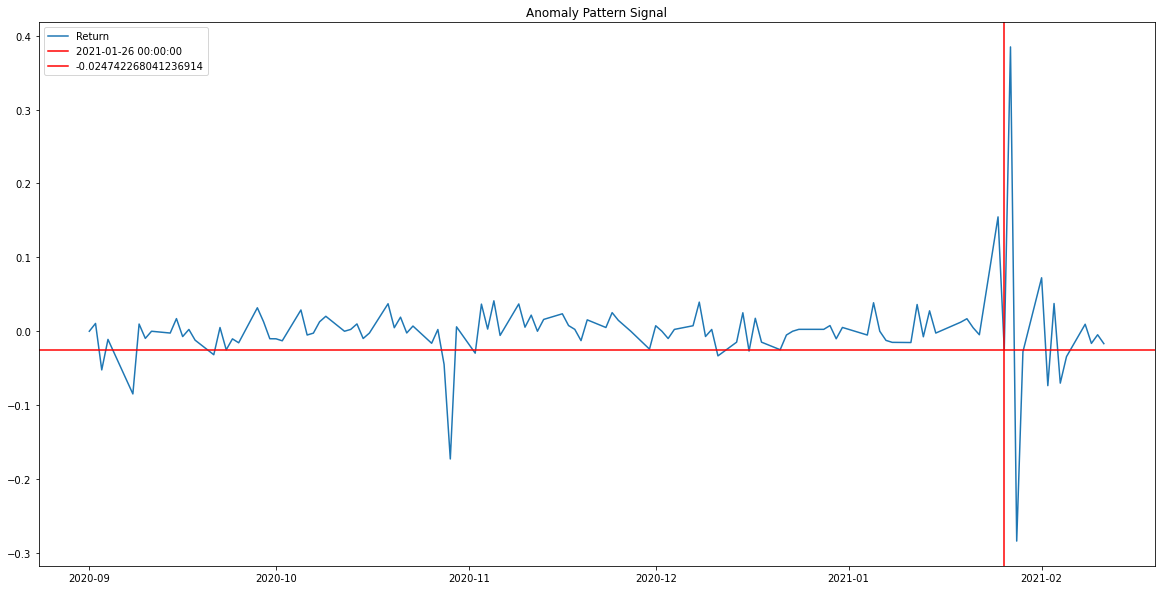

In [479]:
# Visulisation of the Anomaly Signal
plotAnomaly(df_test, "Return")

# Verification

In [480]:
# Check Date in Range for Reddit
def check_range_R(start, end):
    for i in range(len(Reddit_Anomaly['Date'])):
        if start <= Reddit_Anomaly['Date'][i] <= end:
            return 1

In [481]:
# Check Date in Range for Twitter
def check_range_T(start, end):
    for i in range(len(Twitter_Anomaly['Date'])):
        if start <= Twitter_Anomaly['Date'][i] <= end:
            return 1

In [482]:
# Check Date in Range for Crisis
def check_C(date):
    for i in range(len(crisis_period)):
        if crisis_period['Start'][i] <= date <= crisis_period['End'][i]:
            return 1

In [483]:
# Define Final Verification Function
def final_verify(data): ### Data = Anomaly_Table['Date']
    Date = []
    Reddit = []
    Twitter = []
    Crisis = []
    for i in range(len(data)):
        r = 0
        tw = 0
        start = data[i] - timedelta(weeks = 4)
        r = check_range_R(start, data[i])
        tw = check_range_T(start, data[i])
        if r == 1 or tw == 1:
            Date.append(data[i])
            Reddit.append(r)
            Twitter.append(tw)
    verified_anomaly = pd.DataFrame({'Date': Date, 'Reddit': Reddit, 'Twitter': Twitter})
    for i in range(len(verified_anomaly)):
        c = 0
        c = check_C(verified_anomaly['Date'][i])
        if c == 1:
            Crisis.append('Yes')
        else:
            Crisis.append('No')
    verified_anomaly['Crisis Environment'] = Crisis
    return verified_anomaly

## Obtain Final Result

In [484]:
# Get Result
final_result = final_verify(Anomaly_Table['Date'])

In [485]:
# Check Result
final_result

,Date,Reddit,Twitter,Crisis Environment
0,2021-01-26,1,1,Yes
1,2021-01-27,1,1,Yes
2,2021-01-28,1,1,Yes
3,2021-01-29,1,1,Yes
4,2021-02-01,1,1,Yes
5,2021-02-02,1,1,Yes
6,2021-02-03,1,1,Yes
7,2021-02-04,1,1,Yes


# Evaluation

In [486]:
# def TP function
def TP(start_date):
    count = 0
    for i in range(len(Anomaly_Table)):
        if start_date <= Anomaly_Table['Date'][i]:
            count = count + 1
    return count

In [487]:
# def FP function
def FP(start_date):
    count = 0
    for i in range(len(Anomaly_Table)):
        if Anomaly_Table['Date'][i] <= start_date:
            count = count + 1
    return count

In [488]:
# def FN function
def AC(start_date, end_date):
    count = 0
    for i in range(len(X)):
        if start_date <= X.index[i] <= end_date:
            count = count + 1
    return count

In [489]:
# Def Metrics Result Function
def ev_metrics(): # Data = final_result['Date']
    start_date = datetime(2021,1,1)
    end_date = datetime(2021,1,31)
    Total = len(X)
    Anomalies = AC(start_date, end_date)
    tp = TP(start_date)
    fp = FP(start_date)
    fn = Anomalies - tp
    tn = Total - Anomalies - fp
    Accuracy = (tp + tn)/Total
    Percision = tp/(tp + fp)
    Recall = tp/(tp + fn)
    F = 2*(Percision * Recall)/(Percision + Recall)
    print("The evaluation metrics for the result are:")
    print("True Positive:" + str(tp))
    print("False Positive:" + str(fp))
    print("False Negative:" + str(fn))
    print("True Negative:" + str(tn))
    print("Total Number of Anomalies Present:" + str(Anomalies))
    print("Total Number of Data Tested:" + str(Total))
    print("#####################")
    print("Accuracy:" + str(Accuracy))
    print("Percision:" + str(Percision))
    print("Recall:" + str(Recall))
    print("F1-score:" + str(F))

In [490]:
# If No Result Found:
def ev_metrics2():
    start_date = datetime(2021,1,1)
    end_date = datetime(2021,1,31)
    Total = len(X)
    Anomalies = AC(start_date, end_date)
    print("Total Number of Anomalies Present:" + str(Anomalies))
    print("Total Number of Data Tested:" + str(Total))

## Metrics Result

In [491]:
# Obtain Evaluation Result
ev_metrics()

The evaluation metrics for the result are:
True Positive:8
False Positive:0
False Negative:11
True Negative:94
Total Number of Anomalies Present:19
Total Number of Data Tested:113
#####################
Accuracy:0.9026548672566371
Percision:1.0
Recall:0.42105263157894735
F1-score:0.5925925925925926


# Requirement Analysis

In [492]:
# Define Model Fit Function for Iteration Purpose
def DTWfit_i(X_t):
    model_X_temp = TimeSeriesKMeans(n_clusters = number_of_clusters, metric = algorithm, max_iter = 25)
    model_X_temp.fit(X_t) ### Fit the Model
    Xc = model_X_temp.cluster_centers_
    XL = model_X_temp.labels_
    s = min_size ### smallest cluster size
    idx = []
    for i in range(number_of_clusters): ### define functions to find clusters smaller than s
        if np.count_nonzero(XL == i) <= s:
            idx.append(i)
            print(len(idx), "cluster has a size smaller than", s, "and is removed.")
    Xc = np.delete(Xc, idx, axis = 0) ### remove clusters smaller than s
    if len(idx) == 0:
        model_X = model_X_temp
    else:
        model_X = TimeSeriesKMeans(n_clusters = len(Xc), metric = algorithm, max_iter = 25)
        model_X.fit(X_t) ### Fit the model again using updated cluster-size.
    return model_X

In [493]:
# Define Threshold Function for iteration
def find_th(X_t, z = 3): ### X_t is training dataset; m: multiplier (default is 3)
    XDM = []
    d_X = mod_X.cluster_centers_
    XL = mod_X.labels_
    for i in range (len(X_t)): # Compute Union of Distance Matrix
        j = XL[i]
        dist = dtw_dist(X_t[i], d_X[j]) 
        XDM.append(dist)
    q75, q25 = np.percentile(XDM, [75 ,25])
    iqr = q75 - q25 ### Compute inter-quartile range
    X_threshold = z * max(XDM) ### Define threshold using max-distance in traning data-set (three-scaled reference Diab et al.)
    print("The max distance found is", max(XDM), ".")
    return X_threshold

In [494]:
# Define Labelling Function Component for Iteration
def Labe(X_in, Thres): ### X_in: Streaming Input
    X_int = [X_in]
    d_X = model_X.cluster_centers_
    j = model_X.predict(X_int)[0]
    d = dtw_dist(np.reshape(X_in, (5,1)), d_X[j]) ###
    if d > Thres:
        return 1
    else:
        return 0

In [495]:
# Define lableing Function for iteration
def lab_X(inputs, threshold, X_l): ### inputs: Data to be detected, X_l: array to store the label
    nt = next(inputs, "Err")
    if isinstance(nt, str) == True:
        print ("no more value")
    else:
        nt = nt.reshape(5, 1)
        tl = Labe(nt, threshold)
        X_l.append(tl)

In [496]:
# Define Function that signals the first Anomaly Pattern Instance in January
def SignalAnomaly2(X_lb, size):
        if len(X_lb) < size:
            print("Not enough data.")
        else:
            ref_W = X_lb[0:size]
        for i in range(len(X_lb)-(size-1)):
            det_W = X_lb[i:i+size]
            pval = HT(ref_W, det_W)
            if pval < 0.05 and datetime(2021,1,1) < X.index[i+size]:
                return X.index[i+size] ###

In [497]:
# Define Count the Successful Detections Function
def countsucc(start_date = datetime(2021,1,1), end_date = datetime(2021,1,25)):
    count = 0
    for i in range(len(signals)):
        if start_date <= signals[i] <= end_date:
            count = count + 1
    return count

## Obtain Requirement Evaluation Results

# IMPORTANT: Change THRESHOLD MULTIPLIER HERE

In [498]:
# Perform the Test
signals = []
for i in range(100):
    mod_X = DTWfit_i(X_t)
    Thres = find_th(X_t, 1)
    myli = iter(window(X)) # Convert the np.Array into iterations to represent the streaming data environment.
    X_l = []
    for i in range (len(list(window(X)))):
        lab_X(myli, Thres, X_l)
    signal = SignalAnomaly2(X_l, 5)
    signals.append(signal)

1 cluster has a size smaller than 2 and is removed.
The max distance found is 0.41143372694889524 .
1 cluster has a size smaller than 2 and is removed.
The max distance found is 0.3837506434329948 .
1 cluster has a size smaller than 2 and is removed.
The max distance found is 0.26929622744375614 .
1 cluster has a size smaller than 2 and is removed.
The max distance found is 0.2544728243265111 .
1 cluster has a size smaller than 2 and is removed.
The max distance found is 0.37915865683082434 .
1 cluster has a size smaller than 2 and is removed.
The max distance found is 0.23018000207241934 .
1 cluster has a size smaller than 2 and is removed.
The max distance found is 0.24721506327052217 .
1 cluster has a size smaller than 2 and is removed.
The max distance found is 0.24015654608684162 .
1 cluster has a size smaller than 2 and is removed.
The max distance found is 0.265193100375239 .
1 cluster has a size smaller than 2 and is removed.
The max distance found is 0.265193100375239 .
1 clus

1 cluster has a size smaller than 2 and is removed.
The max distance found is 0.3210484358368354 .
1 cluster has a size smaller than 2 and is removed.
The max distance found is 0.25881571303170514 .
1 cluster has a size smaller than 2 and is removed.
2 cluster has a size smaller than 2 and is removed.
The max distance found is 0.45472034765128844 .
1 cluster has a size smaller than 2 and is removed.
The max distance found is 0.3502609119327382 .
1 cluster has a size smaller than 2 and is removed.
The max distance found is 0.2803792687721615 .
1 cluster has a size smaller than 2 and is removed.
The max distance found is 0.449030810784242 .
The max distance found is 0.2672778956224851 .
1 cluster has a size smaller than 2 and is removed.
The max distance found is 0.2366964520602722 .
1 cluster has a size smaller than 2 and is removed.
The max distance found is 0.3210484358368354 .
1 cluster has a size smaller than 2 and is removed.
The max distance found is 0.4459456318849073 .
1 cluster

# #################################

In [499]:
# Display Results
signals

[Timestamp('2021-01-26 00:00:00'),
 Timestamp('2021-01-26 00:00:00'),
 Timestamp('2021-01-26 00:00:00'),
 Timestamp('2021-01-26 00:00:00'),
 Timestamp('2021-01-26 00:00:00'),
 Timestamp('2021-01-26 00:00:00'),
 Timestamp('2021-01-26 00:00:00'),
 Timestamp('2021-01-26 00:00:00'),
 Timestamp('2021-01-26 00:00:00'),
 Timestamp('2021-01-26 00:00:00'),
 Timestamp('2021-01-26 00:00:00'),
 Timestamp('2021-01-26 00:00:00'),
 Timestamp('2021-01-26 00:00:00'),
 Timestamp('2021-01-26 00:00:00'),
 Timestamp('2021-01-26 00:00:00'),
 Timestamp('2021-01-26 00:00:00'),
 Timestamp('2021-01-26 00:00:00'),
 Timestamp('2021-01-26 00:00:00'),
 Timestamp('2021-01-26 00:00:00'),
 Timestamp('2021-01-26 00:00:00'),
 Timestamp('2021-01-26 00:00:00'),
 Timestamp('2021-01-26 00:00:00'),
 Timestamp('2021-01-26 00:00:00'),
 Timestamp('2021-01-26 00:00:00'),
 Timestamp('2021-01-26 00:00:00'),
 Timestamp('2021-01-26 00:00:00'),
 Timestamp('2021-01-26 00:00:00'),
 Timestamp('2021-01-26 00:00:00'),
 Timestamp('2021-01-

In [500]:
# Count
succ_count = countsucc()

In [501]:
# Display Results
succ_count

0